In [1]:
from netCDF4 import Dataset
import numpy as np

dataset = Dataset('Martin_snapshot_spatial.nc')

In [2]:
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print('\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print ("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim )
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [3]:
nc_attrs, nc_dims, nc_vars = ncdump(dataset)

NetCDF Global Attributes:
NetCDF dimension information:
	Name: longitude
		size: 127
	Name: latitude
		size: 254
	Name: depth
		size: 1
	Name: time
		size: 1
	Name: class
		size: 4
	Name: n_obs
		size: 24
NetCDF variable information:
	Name: lon
		dimensions: ('longitude', 'latitude')
		size: 32258
		type: dtype('float64')
		units: 'degrees_east'
		axis: 'X'
	Name: lat
		dimensions: ('longitude', 'latitude')
		size: 32258
		type: dtype('float64')
		units: 'degrees_north'
		axis: 'Y'
	Name: dpt
		dimensions: ('depth',)
		size: 1
		type: dtype('float64')
		units: 'm'
		axis: 'Z'
	Name: tim
		dimensions: ('time',)
		size: 1
		type: dtype('float64')
		units: 'days since 1950-01-01 00:00:00'
		axis: 'T'
	Name: temperature
		dimensions: ('longitude', 'latitude', 'depth', 'time')
		size: 32258
		type: dtype('float64')
		units: 'degC'
	Name: labels
		dimensions: ('longitude', 'latitude', 'time')
		size: 32258
		type: dtype('float64')
		long_name: 'Attributed class'
	Name: posteriors
		dimension

In [27]:
long = np.array(dataset['lon'])
lat = np.array(dataset['lat'])

lab = np.array(dataset['labels'])
lab = np.reshape(lab, (127,254))

posteriors = dataset['posteriors']

posteriors = np.reshape(posteriors,(4,127,254))


[  1.   2.   3. ...,  nan  nan  nan]


C:\Users\Martin\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
C:\Users\Martin\Miniconda3\envs\myenv\lib\site-packages\numpy\core\numeric.py:531: RuntimeWarning: invalid value encountered in greater
  return array(a, dtype, copy=False, order=order)


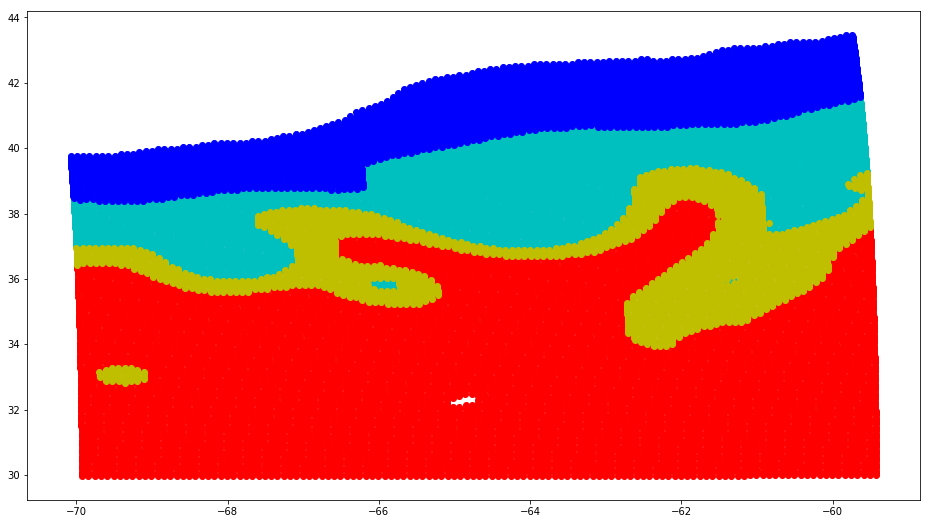

In [132]:
pylab.rcParams['figure.figsize'] = (16.0, 9.0)

colors = ['c','r','y','b']

for k in range(1,5):
    ind = np.where(lab == k)
    scatter(long[ind[0],ind[1]], lat[ind[0],ind[1]], color=colors[k-1])

C:\Users\Martin\Miniconda3\envs\myenv\lib\site-packages\numpy\core\numeric.py:531: RuntimeWarning: invalid value encountered in greater
  return array(a, dtype, copy=False, order=order)
C:\Users\Martin\Miniconda3\envs\myenv\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


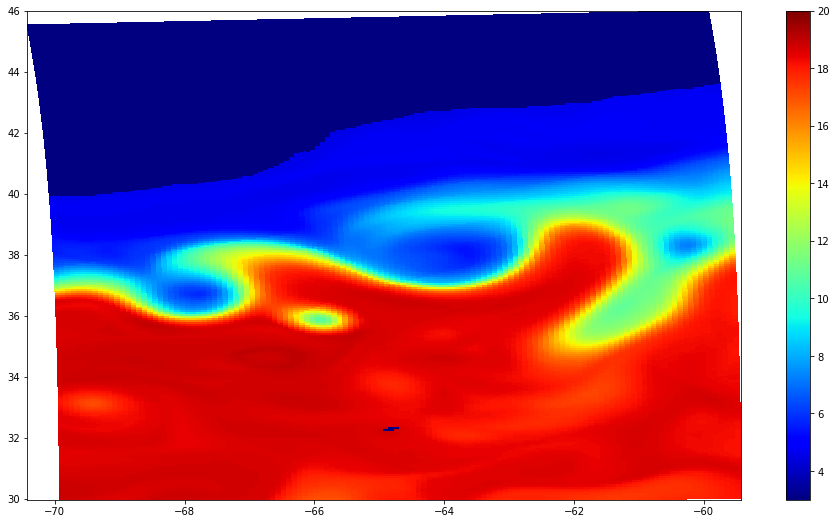

In [13]:
pylab.rcParams['figure.figsize'] = (16.0, 9.0)
temp = np.reshape(dataset['temperature'],(127,254))
fig, ax = subplots()
p = ax.pcolor(long, lat, temp, cmap=cm.jet, vmin=3, vmax=20)
cb = fig.colorbar(p)

In [5]:
obs_lon = dataset['obs_lon']
obs_lat = dataset['obs_lat']

Populating the interactive namespace from numpy and matplotlib


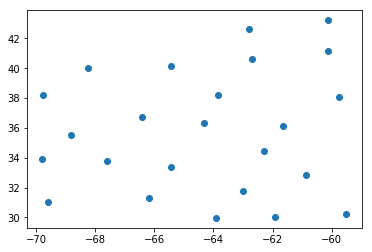

In [42]:
%pylab inline
scatter(obs_lon,obs_lat)

Populating the interactive namespace from numpy and matplotlib
(array([16, 17, 21], dtype=int64),)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 13, 14], dtype=int64),)
(array([10, 12, 15], dtype=int64),)
(array([18, 19, 20, 22, 23], dtype=int64),)


C:\Users\Martin\Miniconda3\envs\myenv\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['long']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


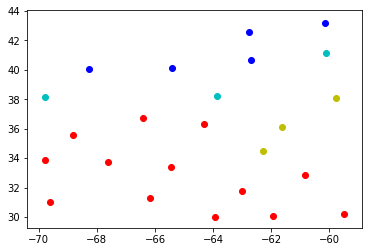

In [6]:
%pylab inline
figure()
obs_ilon = np.array(dataset['obs_ilon']).astype(int)
obs_ilat = np.array(dataset['obs_ilat']).astype(int)
class_obs = lab[obs_ilon,obs_ilat]
colors = ['c','r','y','b']

ind_classes = []
for k in range(1,5):
    ind = np.where(class_obs == k)
    print(ind)
    ind_classes.append(ind)
    scatter(obs_lon[ind], obs_lat[ind], color=colors[k-1])

In [76]:
from math import *

#geodesic distance in km
def dist_geo(long1, lat1, long2, lat2):
    try:
        value= sin(lat1*2*pi/360)*sin(lat2*2*pi/360) + cos(lat1*2*pi/360)*cos(lat2*2*pi/360)\
                    *cos((long2 - long1)*2*pi/360)
        return acos(min(1,value))*6378
    except ValueError:
        print(long1, lat1, long2, lat2,sin(lat1*2*pi/360)*sin(lat2*2*pi/360) + cos(lat1*2*pi/360)*cos(lat2*2*pi/360)\
                    *cos((long2 - long1)*2*pi/360))

vdist_geo = np.vectorize(dist_geo, excluded=['long1', 'lat1'])

def get_knearest(longs, lats, points, indices, k):
    distances = vdist_geo(longs, lats, points[:,0], points[:,1])
    s_distances, s_neigh = (np.array(t) for t in zip(*sorted(zip(distances, indices))))
    return s_distances[:k], s_neigh[:k]


def alpha(distances, i, coeff):
    return exp(-distances[i]/coeff)/sum(np.exp(-np.array(distances)/coeff))

def valpha(distances, coeff):
    l = len(distances)
    alphas = np.zeros((l,))
    for i in range(l):
        alphas[i] = alpha2(distances, i, coeff)
    return alphas


In [122]:
k = 4
kprime = 3
coeff = 50
coeffprime = 300
bad_temp = np.zeros((127,254))
good_temp = np.zeros((127,254))
very_good_temp = np.zeros((127,254))
est_post = np.zeros((4,127,254))
gaus_mean = np.array([7.70938140771444, 18.5364702094555, 15.4116575244064, 4.702268415742165])
for i in range(127):
    for j in range(254):
        if np.isnan(lab[i,j]) == False:
            lon = long[i,j]
            lati = lat[i,j]
            distances, knearest = get_knearest(lon, lati, np.column_stack((obs_lon, obs_lat)),\
                                               np.column_stack((obs_ilon, obs_ilat)), k)
            
            alphas = valpha(distances, coeff)
            bad_temp[i,j] = sum(alphas*temp[knearest[:,0],knearest[:,1]])
            est_post[:,i,j] = alphas.dot(np.transpose(posteriors[:,knearest[:,0],knearest[:,1]]))
            good_temp[i,j] = sum(est_post[:,i,j]*gaus_mean)
            
            

C:\Users\Martin\Miniconda3\envs\myenv\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


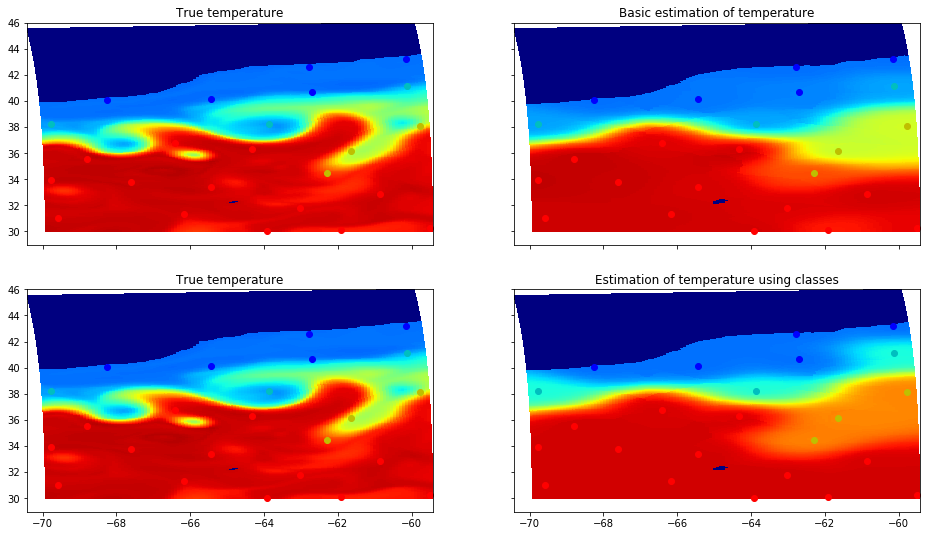

In [126]:
pylab.rcParams['figure.figsize'] = (16,9)

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row')
p = axarr[0,0].pcolor(long, lat, temp, cmap=cm.jet, vmin=0, vmax=20)
axarr[0,0].set_title('True temperature')
p = axarr[0,1].pcolor(long, lat, bad_temp, cmap=cm.jet, vmin=0, vmax=20)
axarr[0,1].set_title('Basic estimation of temperature')
p = axarr[1,0].pcolor(long, lat, temp, cmap=cm.jet, vmin=0, vmax=20)
axarr[1,0].set_title('True temperature')
p = axarr[1,1].pcolor(long, lat, good_temp, cmap=cm.jet, vmin=0, vmax=20)
axarr[1,1].set_title('Estimation of temperature using classes')

for k in range(1,5):
    ind = np.where(class_obs == k)
    for i in range(2):
        for j in range(2):
            p = axarr[i,j].scatter(obs_lon[ind], obs_lat[ind], color=colors[k-1])

C:\Users\Martin\Miniconda3\envs\myenv\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


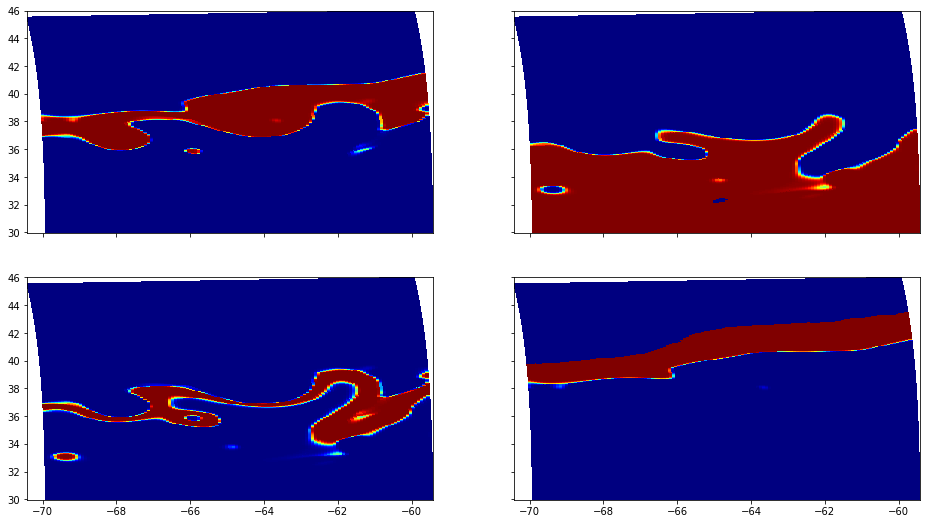

In [426]:
pylab.rcParams['figure.figsize'] = (16.0, 9.0)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
p = ax1.pcolor(long, lat, posteriors[0,:,:], cmap=cm.jet, vmin=0, vmax=1)
p = ax2.pcolor(long, lat, posteriors[1,:,:], cmap=cm.jet, vmin=0, vmax=1)
p = ax3.pcolor(long, lat, posteriors[2,:,:], cmap=cm.jet, vmin=0, vmax=1)
p = ax4.pcolor(long, lat, posteriors[3,:,:], cmap=cm.jet, vmin=0, vmax=1)
cb = fig.colorbar(p)

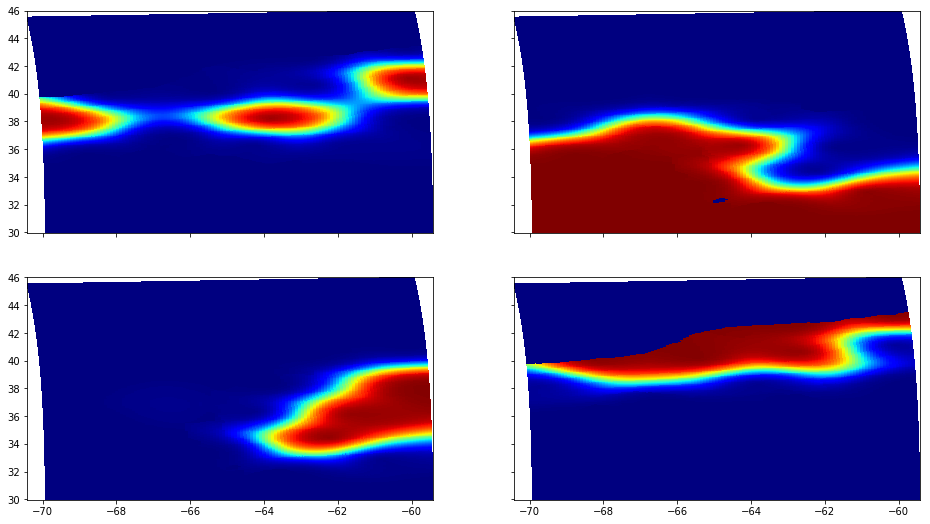

In [92]:
pylab.rcParams['figure.figsize'] = (16.0, 9.0)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
p = ax1.pcolor(long, lat, est_post[0,:,:], cmap=cm.jet, vmin=0, vmax=1)
p = ax2.pcolor(long, lat, est_post[1,:,:], cmap=cm.jet, vmin=0, vmax=1)
p = ax3.pcolor(long, lat, est_post[2,:,:], cmap=cm.jet, vmin=0, vmax=1)
p = ax4.pcolor(long, lat, est_post[3,:,:], cmap=cm.jet, vmin=0, vmax=1)
cb = fig.colorbar(p)